# 1. Install and Import Dependencies

In [14]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

^C


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [ ]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!pip install mss pydirectinput pytesseract

In [ ]:
#chrome://dino/

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(5)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 200, 'width': 300, 'height': 500}
        self.done_location = {'top': 100, 'left': 200, 'width': 660, 'height': 70}
        self.map_accuracy =  {'top': 70, 'left': 940, 'width': 65, 'height': 50}
        
        
    def step(self, action):
        #action key d = far left tile, f = second from left, j = second right, k = far right, no_op = no action
        action_map = {
            0:'d',
            1: 'f', 
            2: 'j',
            3: 'k',
            4: 'no_op'
        }
        if action !=4:
            pydirectinput.press(action_map[action])

        #map_acc, map_percent = self.get_accuracy()
        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1
        info = {}
        #return observation, reward, done, info, map_percent
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=515, y=432)
        #pydirectinput.press('space')
        return self.get_observation()
        
    """ def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close() """
        
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_accuracy(self):
        map_acc = np.array(self.cap.grab(self.map_accuracy))
        res = pytesseract.image_to_string(map_acc)[:4]
        return map_acc, float(res)
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['FAIL', 'FAILED']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

# 2.2 Test Environment

In [3]:
env = WebGame()

In [4]:
obs=env.get_observation()

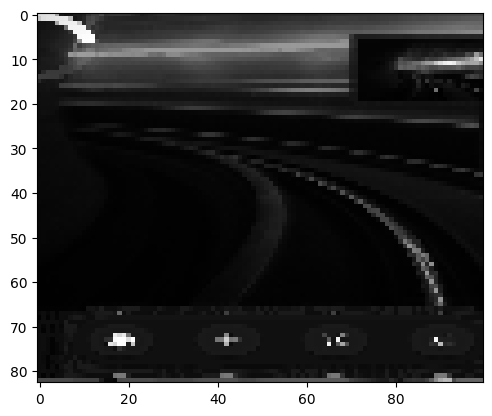

In [9]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [6]:
done, done_cap = env.get_done()

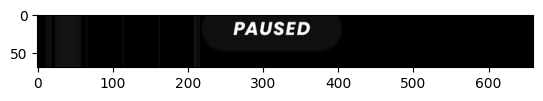

In [ ]:
plt.imshow(done_cap)

In [10]:
pytesseract.image_to_string(done_cap)[:4]

'vv L'

In [11]:
done

False

In [10]:
#map_acc, map_percent = env.get_accuracy()

ValueError: could not convert string to float: ''

In [11]:
#plt.imshow(map_acc)

NameError: name 'map_acc' is not defined

In [ ]:
#pytesseract.image_to_string(map_acc)[:4]

'100.'

In [12]:
for episode in range(1): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        #obs, reward,  done, info, map_percent =  env.step(env.action_space.sample())
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
        """ if (map_percent < 70):
            total_reward -= reward -2 """
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

KeyboardInterrupt: 

# 3. Train the Model

## 3.1 Create Callback

In [13]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = './train'
LOG_DIR = './logs'

In [16]:
callback = TrainAndLoggingCallback(check_freq=1500, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [17]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [18]:
env = WebGame()

In [19]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=0)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\liamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [21]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs\DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51       |
|    ep_rew_mean      | 51       |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 81       |
|    total_timesteps  | 204      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000266 |
|    n_updates        | 114      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 50.5     |
|    ep_rew_mean      | 50.5     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 156      |
|    total_timesteps  | 404      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00025

KeyboardInterrupt: 

In [ ]:
model.load('./train/') 

# 4. Test out Model

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)